In [94]:
from typing import List
import cv2
import pandas as pd
import os
import numpy as np

# %matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
plt.rcParams["figure.figsize"] = (20,3)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
# csv_path = "./data/1046.csv"
# vid_path = "./data/1046.avi"

csv_path = "./exp/csvs/1049.csv"
vid_path = "./exp/vids/1049.avi"

### The gaol here is to find a way to determine time of death using the outputs from yolov3 and the video.

## Road Map:
1. Locate areas of interest
2. Analyze areas of interest
3. Determine if the area of interest has movement

In [119]:
# Helper Functions

def get_worms(image, bbs):
    """ Takes image and list of bbs and returns a list of the
    cutouts for each worm"""
    worms = []
    for bb in bbs:
        bb = bb.astype(int)
        x, y, w, h = bb
        worm = image[y:y+h, x:x+w]
        worms.append(worm)
    
    return worms


def display_worms(worms: list[np.ndarray]):
    """List of worm images and then makes a figure with all
    the worms"""
    worm_count = len(worms)
    fig = plt.figure()
    
    for i in range(worm_count):
        fig.add_subplot(1, int(worm_count), i + 1)
        plt.imshow(worms[i])
        plt.axis('off')
    
    plt.show(block=True)
    

    

In [120]:
# Loads csv
class CSV_Reader():

    def __init__(self, csv, vid):
        """ Reads the csv and video and provides useful functions for determining
        time of death"""
        self.csv = csv
        self.vid = vid
        
        video = cv2.VideoCapture(vid)
        self.video = video
        self.frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        
        
        self.df = pd.read_csv(csv, names=["frame", "x", "y", "w", "h", "class"])
        
    def get_worms_from_frame(self, frame_id):
        """ Gets the frame image from a frame id,
        and then the bounding boxes associated with that image"""
        frame = self.video.get(frame_id)
        self.video.set(cv2.CAP_PROP_POS_FRAMES, frame_id - 1)
        ret, frame = self.video.read()
        bbs = self.df[self.df["frame"] == frame_id]
        bbs = bbs.to_numpy()
        bbs = bbs[:, 1:5]
        return frame, bbs
        

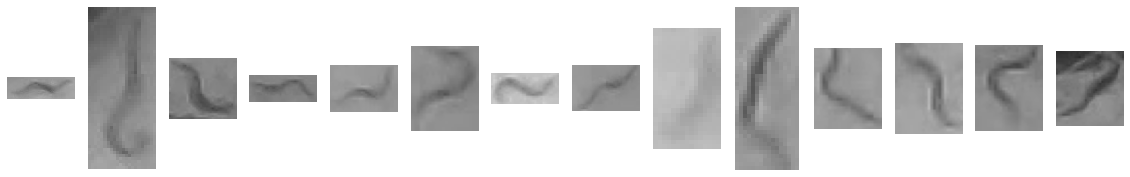

In [121]:
a = CSV_Reader(csv_path, vid_path)

frame, bbs = a.get_worms_from_frame(206)
worms = get_worms(frame, bbs)
display_worms(worms)

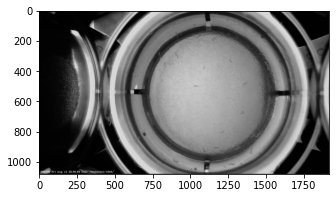

In [122]:
plt.imshow(cv2.normalize(frame, frame, 0, 255, cv2.NORM_MINMAX))

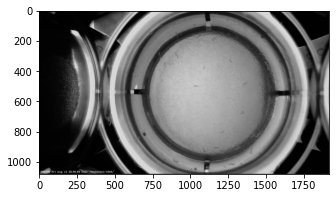

In [123]:
plt.imshow(frame)

In [124]:
df = pd.read_csv(csv_path, names=["frame", "x", "y", "w", "h", "class"])
df

,frame,x,y,w,h,class
0,1.0,1046,901,24,29,worm
1,1.0,1454,885,32,23,worm
2,1.0,1194,783,28,25,worm
3,1.0,1195,563,12,34,worm
4,1.0,823,554,35,19,worm
...,...,...,...,...,...,...
35957,2499.0,1168,652,18,28,worm
35958,2499.0,865,593,33,22,worm
35959,2499.0,1153,496,41,18,worm
35960,2499.0,1196,208,19,34,worm


In [125]:
bbs

array([[1245, 1006, 59, 19],
       [1391, 898, 22, 53],
       [1079, 909, 35, 32],
       [1156, 899, 42, 17],
       [1193, 791, 33, 23],
       [1333, 665, 23, 29],
       [1023, 494, 33, 15],
       [1341, 474, 38, 26],
       [1080, 366, 15, 27],
       [826, 335, 16, 41],
       [1259, 319, 24, 29],
       [902, 287, 25, 34],
       [1145, 183, 25, 32],
       [1042, 152, 33, 37]], dtype=object)

In [126]:
def show_section(bb):
    bb = bb.astype(int)
    x, y, w, h = bb
    cut = frame[y:y+h, x:x+w]
    plt.imshow(cut)
    return cut

# Experiment with different image transformations.

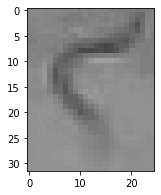

In [127]:
img = show_section(bbs[12])

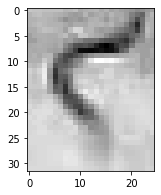

In [128]:
plt.imshow(cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX))

array([[[187, 187, 187],
        [186, 186, 186],
        [185, 185, 185],
        ...,
        [136, 136, 136],
        [143, 143, 143],
        [145, 145, 145]],

       [[187, 187, 187],
        [186, 186, 186],
        [186, 186, 186],
        ...,
        [134, 134, 134],
        [142, 142, 142],
        [146, 146, 146]],

       [[185, 185, 185],
        [185, 185, 185],
        [185, 185, 185],
        ...,
        [132, 132, 132],
        [143, 143, 143],
        [150, 150, 150]],

       ...,

       [[216, 216, 216],
        [216, 216, 216],
        [217, 217, 217],
        ...,
        [204, 204, 204],
        [205, 205, 205],
        [205, 205, 205]],

       [[216, 216, 216],
        [216, 216, 216],
        [217, 217, 217],
        ...,
        [204, 204, 204],
        [206, 206, 206],
        [206, 206, 206]],

       [[216, 216, 216],
        [216, 216, 216],
        [217, 217, 217],
        ...,
        [204, 204, 204],
        [206, 206, 206],
        [206, 206, 206]]

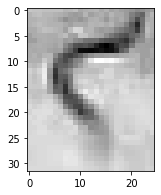

In [129]:
t = show_section(bbs[12])
cv2.blur(t, (5,5))

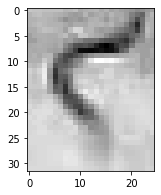

In [130]:
plt.imshow(t)
sgray = cv2.cvtColor(t, cv2.COLOR_BGR2GRAY)

In [131]:
w = t.shape[1] * 4
h = t.shape[0] * 4
resized = cv2.resize(t, (w, h), interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

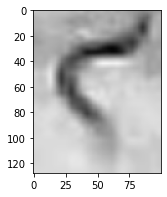

In [132]:
plt.imshow(cv2.blur(resized, (5,5)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


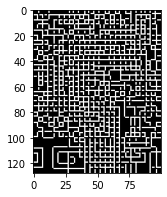

In [133]:
laplacian = cv2.Laplacian(resized, cv2.CV_64F)
plt.imshow(laplacian)

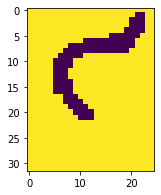

In [134]:
ret, thresh = cv2.threshold(sgray, 120, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)

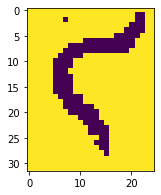

In [135]:
th2 = cv2.adaptiveThreshold(sgray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,22)
plt.imshow(th2)

## Start testing on the videos of individual worms.

___Goal is to identify when the worm moves or leaves the bounding box area.___

In [136]:
# %matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

worm_video = "results/1.avi"
video = cv2.VideoCapture(worm_video)
count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
# ret, frame = video.read()
# plt.imshow(frame)

def fetch_frame(frame_id):
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = video.read()
    return frame

In [137]:
# Image transformation function

def normalization(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.normalize(frame, frame, 0, 255, cv2.NORM_MINMAX)
    return frame

def transformation(frame):
    frame = cv2.adaptiveThreshold(frame, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,22)
    return frame

In [138]:
worms = []

for i in range(0, count, 25):
    frame = fetch_frame(i)
    frame = normalization(frame)
    frame = transformation(frame)
    worms.append(frame)

display_worms(worms)

<Figure size 1440x216 with 0 Axes>

In [139]:
def calc_dif(a, b):
    a = cv2.blur(a,(2,2))
    b = cv2.blur(b,(2,2))
    
#     plt.imshow(blur)
    out = np.empty((42,26))
    diff = cv2.absdiff(a, b)
    return diff

def compute_score(worms, count=15, gap=5):
    xshape, yshape = worms[0].shape
    pixel_count = xshape * yshape
    
    differences = []
    for i, worm in enumerate(worms):
        totals = []
        low = max(0, i - count)
        for n in range(low, i - gap):
            dif = calc_dif(worms[n], worm)
            totals.append(dif.sum(axis=None))
        
        avg = np.average(totals)
        avg = avg / pixel_count
        differences.append(avg)
    

    return differences

d = calc_dif(worms[11], worms[13])
# plt.imshow(d)
data = compute_score(worms)

axs = plt.subplot()
# fig.set_dpi(100)
axs.plot(data)
axs.set(ylabel = "Total Color Difference", xlabel = "frame")
# axs[0].fi
# axs[0].xlabel("Frame")
display_worms([worms[i] for i in range(0, len(worms), 2)])
plt.show()

IndexError: list index out of range

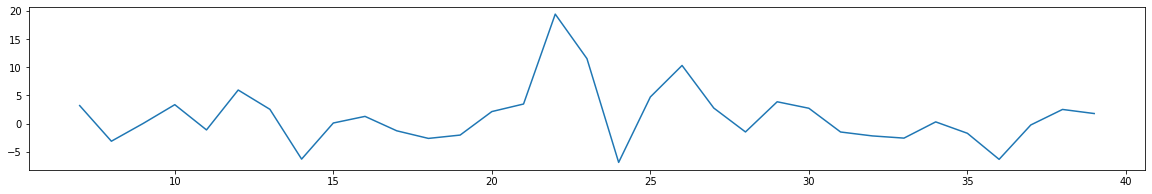

In [140]:
f = np.gradient(data)
plt.plot(f)

In [141]:
worms[0].shape


IndexError: list index out of range

In [142]:
len(worms)

0